## LCM Model:

W ---> l <---- U ----> Y <---- Phi and l --> L

U is the latent process that generates both Ls and Ys here Ls are 0s and 1s and Y are gaussian processes

here also we introduce S trials for each Y. To accomodate these we fold up Y's in vectorized form
#### Now, $Y \in R^{S \times CN}, u \in R^{S \times PN }$ and ${ \bar{\phi} }$ is a block diagonal of size CN X PN with CXP matrix ${\phi}$ on diagonals. Also $W \in R^{1 \times PN}$ 

###  $Y= u * \bar{\phi}^T + \sigma^2I$
###  $l= b + u * W^T + s^2I$
####  L = -1 if l < $\mu$ L = +1 otherwise 

here b is the bias and s denotes the noise in label generation process


##### Also, $u \in GP(0,\bar{K})$ where $\bar{K}$ is also a blaock diagonal of size PN x PN with covariance kernels ${K_p \in R ^{N \times N}}$ for each  gaussian process on diagonals.

In [1]:
### necessary Imports
import numpy as np
import pylab as pb
import scipy as sc
from matplotlib import pyplot as plt
from scipy.stats import multivariate_normal as MNormalDist
import GPy
%pylab inline

Populating the interactive namespace from numpy and matplotlib


Phi
[[0 1]
 [1 0]
 [0 1]
 [1 0]
 [0 1]]


<matplotlib.colorbar.Colorbar instance at 0x7f8dba372a70>

 /usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning:elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


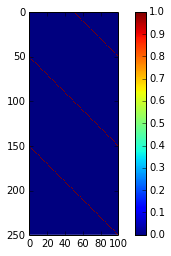

In [2]:
### Data Generation Process
S = 100
P = 2
C = 5
N = 50
s2 = 0.5
x = np.linspace(0,N-1,N)
#phi = np.random.normal(loc=0,scale=1,size=(C,P))
phi = np.array([[0,  1],
                [ 1, 0],
                [0 , 1],
                [ 1 , 0],
                [0 ,1]])
phiBar = np.matrix(np.kron(phi,np.eye(N)))
print "Phi\n",phi
plt.imshow(phiBar,interpolation='none')
plt.colorbar()

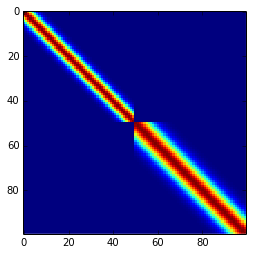

In [3]:
Kp = list()
for p in range(P):
    kenrel = GPy.kern.ExpQuad(1,lengthscale=3+2*p)
    Kp.append(kenrel.K(x.reshape(N,1))+np.eye(N)*0.0001)
#K.append(Kernel.generateKernel(Kernel.linear,x,x,a=0.001))
#K.append(Kernel.generateKernel(Kernel.exponenQuad,x,x,l=2))
Kbar = sc.linalg.block_diag(*Kp)
plt.imshow(Kbar,interpolation='none')

In [10]:
def guessLabel(l,mu=0):
    if l < mu:
        return -1
    else:
        return 1
    

Concatenated Latent Gaussian Processes:


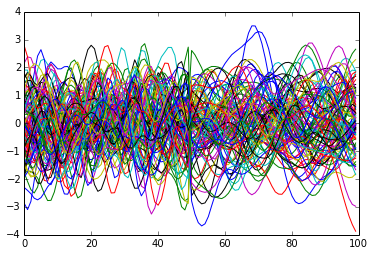

In [403]:
B = np.ones(S)*0.3
W = np.random.rand(P*N)
uBar = np.matrix(np.ones((S,N*P)))
l = np.zeros(S)
L = np.zeros(S)
for s in range(S):
    u = list()
    for p in range(P):
        u.append(np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=Kp[p]))
    us = np.hstack(u)
    uBar[s,:] = us
    l[s] = np.dot(uBar[s,:] ,W) + B[s]
    L[s] = guessLabel(l[s])
print "Concatenated Latent Gaussian Processes:"
i=plt.plot(uBar.T)

Concatenated Latent Gaussian Processes:


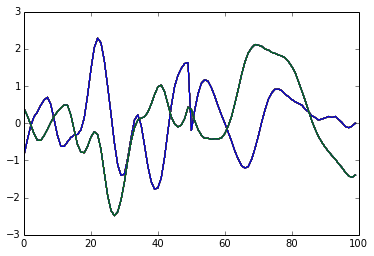

In [5]:
B = np.ones(S)
W = np.random.rand(P*N)
uBar = np.matrix(np.ones((S,N*P)))
l = np.zeros(S)
L = np.zeros(S)
uplus = list()
uminus = list()
for p in range(P):
        uplus.append(np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=Kp[p]))
        uminus.append(np.random.multivariate_normal(mean=np.zeros(N).flatten(),cov=Kp[p]))
        
for s in range(S):
    if s < 0.5*S:
        L[s] = 1
        us = np.hstack(uplus)
    else:
        L[s] = -1
        us = np.hstack(uminus)
    uBar[s,:] = us
    l[s] = np.dot(uBar[s,:] ,W) + B[s]
    #L[s] = guessLabel(l[s])
print "Concatenated Latent Gaussian Processes:"
i=plt.plot(uBar.T)

In [149]:
print C,P,N,phiBar.shape, uBar.shape

3 5 50 (250, 100) (10, 100)


Generated Data:


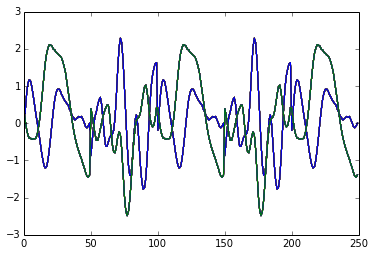

In [6]:
YBar = uBar * phiBar.T
print "Generated Data:"
i=plt.plot(YBar.T)


In [3]:
## Insert real data
import pandas as pd
fname = "synthetic_control.data"
content = [line.strip() for line in open(fname)]
data = []
for c in content:
    data.append(np.array(c.split(' ')))
    newData = []
lens = []
for d in data:
    a = []
    for i,j in enumerate(d):
        if d[i] != '':
            a.append(float(d[i]))
    newData.append(a)
data = pd.DataFrame(newData)
converted = data.transpose()
normalized = (converted - converted.mean())/(converted.max() - converted.min())
normalizedData = normalized.transpose()
def getClassification(k = 'IT'):
    classifier = {
        'N': 100,
        'C': 200,
        'IT':300,
        'DT':400,
        'US':500,
        'DS':600
    }
    A = np.ones(600)*-1
    A[classifier[k]-100:classifier[k]] = 1
    return A
normalizedData['Result'] = getClassification()
normalizedData = normalizedData.sample(frac=1)
from sklearn.cross_validation import train_test_split
Y_train, Y_test, L_train, L_test = train_test_split(normalizedData[normalizedData.columns[0:60]], normalizedData['Result'], test_size=0.4, random_state=0)
from imblearn.over_sampling import SMOTE
smote=SMOTE()
YBar, L = smote.fit_sample(Y_train, L_train)

 /home/sudhanshu/miniconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning:This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.


In [7]:
S = YBar.shape[0]
N = YBar.shape[1]
x = np.linspace(0,N-1,N)

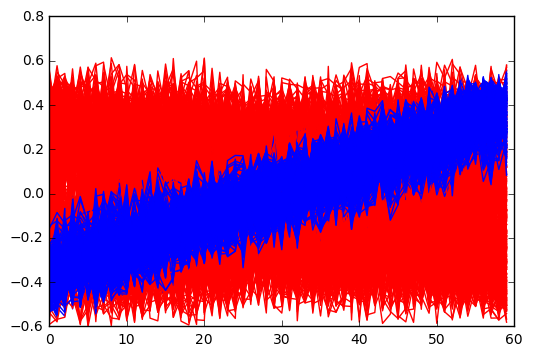

In [6]:
def plotLabel(YBar,L,S):
    for s in range(S):
        if L[s] < 0:
            plt.plot(YBar[s].T,c='r')
        else:
            plt.plot(YBar[s].T,c='b')
plotLabel(YBar,L,S)

### Inference: 

#### Initializations:

Concatenated Latent Gaussian Processes:
(300, 300) (608, 300, 1)


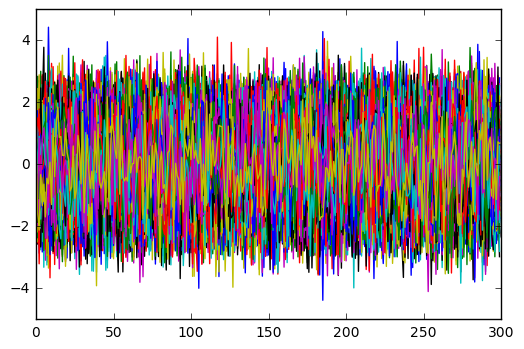

In [11]:
## get random inducing point
## Intialization for variational inference
P=5
C=1
noOfInductions = int(N*1)
n = sort(np.random.choice(x,size=noOfInductions,replace=False))
nBar = np.concatenate([c*N+n for c in range(C)])
NBar = np.concatenate([c*N+x for c in range(C)])
# Create Matrices
Knn = list()
KNn = list()
KnnInv = list()
KNN = list()
ls = [2,2,2,2,2]
for i in range(P):
    kenrel = GPy.kern.ExpQuad(1,lengthscale=ls[i])
    Knn.append(kenrel.K(n.reshape(noOfInductions,1))+np.eye(noOfInductions)*0.0)
    KNn.append(kenrel.K(x.reshape(N,1), n.reshape(noOfInductions,1)))
    KNN.append(kenrel.K(x.reshape(N,1))+np.eye(N)*0.00)
    KnnInv.append(np.linalg.inv(Knn[i]))
Kpnn = np.matrix(sc.linalg.block_diag(*Knn))
KpNn = np.matrix(sc.linalg.block_diag(*KNn))
KpnnInv = np.matrix(sc.linalg.block_diag(*KnnInv))
KpNN = np.matrix(sc.linalg.block_diag(*KNN))
# Generate a guess for phi
phiHatMean = 0
phiHatV = 1
phiHatExp = np.mat(np.random.normal(loc=phiHatMean,scale=phiHatV,size=(C,P)))
phiHatExpBar = np.kron(phiHatExp,np.eye(N))
phiHatVar = np.eye(P)
# Generate a guess for B
BHatMean = 0
BHatV = 1
BHatExp = np.mat(np.random.normal(loc=BHatMean,scale=BHatV,size=(S,1)))
# Generate a guess for W
WHatMean = 0
WHatV = 1
WHatExp = np.mat(np.random.normal(loc=WHatMean,scale=WHatV,size=(1,P*N)))
WHatV = np.eye(P*N)
#Generate samples for latent
uHatMeansBar = np.random.normal(loc=0,scale=1,size=(S,noOfInductions*P,1))
uHatVsBar = np.eye(noOfInductions*P)
uExpBar = np.random.normal(loc=0,scale=1,size=(S,N*P))
print "Concatenated Latent Gaussian Processes:"
i=plt.plot(uExpBar.T)
print uHatVsBar.shape,uHatMeansBar.shape
## Generate Sample for latent labels
lHatExp = (uExpBar * WHatExp.T) + BHatExp
## Get initial label guess
LHat = np.ones(S)
LHat = [guessLabel(lHatExp[s]) for s in range(S)]

### Variational Updates are:

#### For ${\hat{u}}$:

$q(\hat{u}) \propto N(\hat{u}|(y<\phi> + <w><l>\sigma^2 - <w><b>\sigma^2){K}_{pNpn}K_{pn}^{-1}\Sigma_{u}^{-1}, \hat{\Sigma}_{u}^{-1})$
where $ \hat{\Sigma}_{u} = K_{pn}^{-1} + \frac{1}{\sigma^2}K_{pn}^{-1}K_{pnpN}F_uK_{pNpn}K_{pn}^{-1}$
and $F_u = <{\phi}^T{\phi}>_{\phi} + \sigma^2<w^Tw>_w = Var(\phi) + <\phi>^T<\phi> + Var(w) + <w>^T<w>$ , 

#### For ${u}$:

${q(u) \propto N (\hat{\mu}M, \Sigma_{u|u^{p}} + M\Sigma_{u}M^{T})}$


where $\hat{\mu}_{u}$ is the mean and ${\hat{\Sigma}_{u}}$ variance of $\hat{u}$

Also  $\Sigma_{u|u^{p}} = K_{pNpN} - K_{pNpn}K_{pn}^{-1}K_{pnpN}$ , $M = K_{pn}^{-1}K_{pNpn}$

#### For $\phi$:

$\phi = N(\phi| (\bar{V}_{\phi} + I)^{-1}\bar{z}_{\phi}, (\bar{V}_{\phi} + I)^{-1})$
where $\bar{V}_{\phi} = \sum_{s}^{S}(<\bar{u}_s><\bar{u}_s>^T$ + I)
and $\bar{z}_{\phi} = \sum_{s}^{S}<\bar{u}_s>\bar{y}_{s}^T$
here $x = vec(\bar{x})$ 

#### For l:

$q(l_i) \propto TN(l_i| (<w><u> + <b>, 2*I, l_i < \mu)$
where TN is truncated normal distribution

#### For W:

$W \propto N(w | [F_u+I]^{-1}(<U>^T<l>^T - <U>^T<b>^T,[F_u+I]^{-1})$
where $F_u = <{U}^T{U}>_{U}$

#### For B:

$b \propto N(b | (<l>^T - <U><w>^T,I)$


### And lower bound of liklelihood with respect to $u_p$ is given by:

$L(u_p) = log N(F_{p}^{-1}y<\phi> | <U>, F_{p}^{-1} + K_{Nn}K_{nn}^{-1}K_{nN}) - \frac{1}{2}tr(\sum_{i}^{P}{U_i*cov(u_i|\hat{u_i}}))$ - KL divergence terms.. 

where
$ cov(u_p|\hat{u}_p) = K_N - K_{Nn}K_{n}^{-1}K_{nN}$


In [12]:
#Calculate F and Z
def calculateVZ(uVBar):
    Vphi = np.zeros((P,P))
    Zbar = np.zeros((P,C))
    #SUm over S's
    sigma = np.zeros((P,P))
    for p in range(P):
        sigmaPP = uVBar[p*N:p*N+N,p*N:p*N+N]
        #print p, sigma
        sigma[p,p] = np.trace(sigmaPP)
    for s in range(S):
        usBar = uExpBar[s].reshape(P,N)
        ysBar = YBar[s].reshape(C,N)
        Vphi += usBar*usBar.T + sigma
        Zbar += usBar*ysBar.T
    return sigma,Vphi,Zbar

In [15]:
for i in range(100):
    ## Update for uHat
    phiHatExpBar = np.kron(phiHatExp,np.eye(N))
    phiHatVarBar = np.kron(phiHatVar,np.eye(N))
    Fu = phiHatExpBar.T*phiHatExpBar + phiHatVarBar + WHatExp.T*WHatExp + WHatV
    uHatVsBar = np.linalg.inv(KpnnInv + KpnnInv*KpNn.T*Fu*KpNn*KpnnInv)
    uHatMeansBar = (YBar*phiHatExpBar + lHatExp * WHatExp - BHatExp * WHatExp )* KpNn*KpnnInv*uHatVsBar
    #Update for u 
    M = np.matrix(KpnnInv * KpNn.T)
    uExpBar = uHatMeansBar * M
    uVBar = KpNN - KpNn*KpnnInv*KpNn.T + M.T*uHatVsBar*M
    #Update for phi
    sigm,VPhi,Zbar = calculateVZ(uVBar)
    phiHatVar = np.linalg.inv(VPhi + np.eye(P))
    phiHatExp = np.matrix(Zbar.T) * phiHatVar
    #Update for W
    WHatV = np.linalg.inv(uExpBar.T*uExpBar + uVBar + np.eye(uVBar.shape[0]))
    WHatExp =  (lHatExp.T*uExpBar - BHatExp.T*uExpBar )*WHatV
    #Update for B
    BHatExp = (np.ones(S)*np.sum(lHatExp - uExpBar * WHatExp.T)/(S+1)).reshape(S,1)
    #Update for l
    lHatExp = calculateTNMean(WHatExp*uExpBar.T + BHatExp).reshape(S,1)
    
        

In [14]:
from scipy.stats import norm as norm
def calculateTNMean(Mu):
    means = np.zeros(S)
    for s in range(S):
        if L[s] == 1:
            a = 0
            b = np.infty
        else:
            a = -np.infty
            b = 0
        if Mu[0,s] < -5:
            Mu[0,s] = -5
        if Mu[0,s] > 5:
            Mu[0,s] = 5
        alpha = a - Mu[0,s]
        beta = b - Mu[0,s]
        Z = norm.cdf(beta) - norm.cdf(alpha)
        #print beta, alpha,Z
        means[s] = Mu[0,s] + (norm.pdf(alpha) - norm.pdf(beta))/Z
    return means

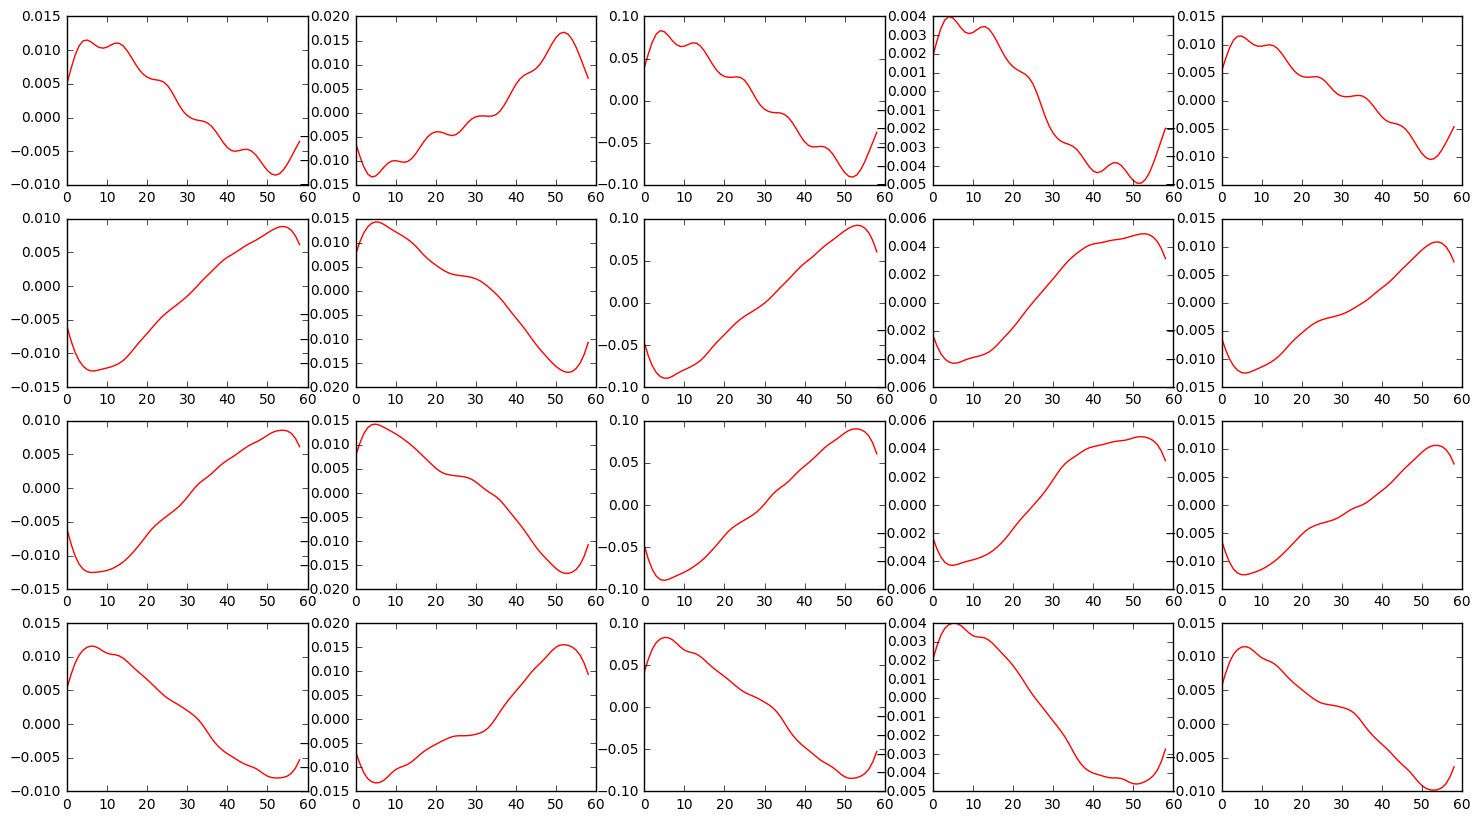

In [22]:
fig,axes = plt.subplots(nrows=2*2,ncols=P,figsize=(18,10))
for i,s in enumerate([0,7,31,4]):
    for p in range(P):
        #if p <= uBar.shape[1]/N:
        #    axes[2*s+0,p].plot(uBar[s,p*N:p*N+N-1].T)
        #else:
        #    axes[2*s+0,p].plot(np.ones(N).T)
        axes[i,p].plot(uExpBar[s,p*N:p*N+N-1].T,c='r')

In [25]:
acc = L ==LHat
acc.mean()


1.0

In [20]:
a = L_train.values
np.where(a==1)

(array([  7,  31,  35,  40,  41,  44,  49,  65,  68,  74,  77,  93,  98,
         99, 102, 106, 108, 116, 121, 123, 125, 129, 131, 137, 139, 151,
        157, 174, 178, 181, 188, 190, 194, 204, 209, 211, 213, 214, 225,
        234, 242, 246, 262, 265, 267, 275, 278, 302, 304, 309, 322, 329,
        330, 335, 336, 350]),)

In [24]:
LHat = [guessLabel(lHatExp[s]) for s in range(S)]
#LHat

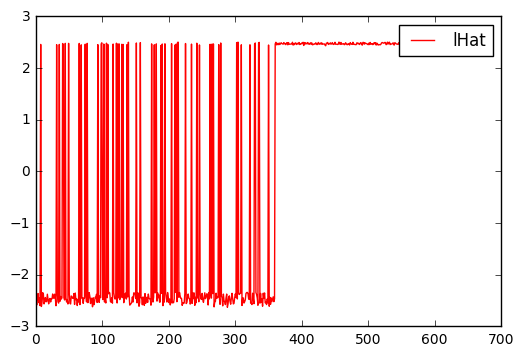

In [26]:
#plt.plot(l,c='b',label='l')
plt.plot(lHatExp,c='r',label='lHat')
plt.legend()

(array([ 11.,  11.,  11.,   8.,   9.,   9.,  12.,   9.,   5.,  15.]),
 array([ 0.01944842,  0.11164369,  0.20383896,  0.29603423,  0.3882295 ,
         0.48042477,  0.57262004,  0.6648153 ,  0.75701057,  0.84920584,
         0.94140111]),
 <a list of 10 Patch objects>)

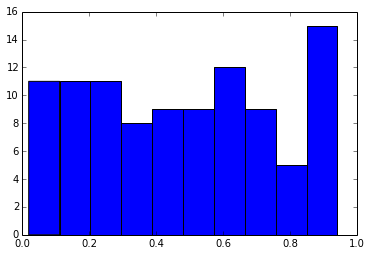

In [41]:
plt.hist(W)

(array([   4.,    7.,   10.,   19.,  164.,   22.,    8.,    5.,    4.,    7.]),
 array([-0.09429888, -0.07473229, -0.0551657 , -0.03559911, -0.01603252,
         0.00353407,  0.02310066,  0.04266725,  0.06223384,  0.08180043,
         0.10136702]),
 <a list of 10 Patch objects>)

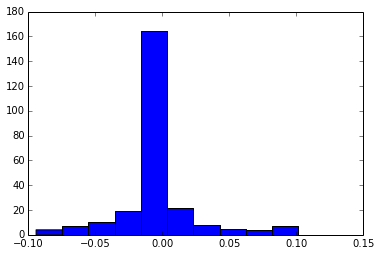

In [43]:
plt.hist(WHatExp.T)

In [59]:
P = 2
uBarTest = np.matrix(np.ones((50,N*P)))
Ltest = np.zeros(50)
for t in range(50):
    if t < 25:
        Ltest[t] = 1
        us = np.hstack(uplus)
    else:
        Ltest[t] = -1
        us = np.hstack(uminus)
    uBarTest[t,:] = us
Ytest = uBarTest * phiBar.T + 2.5*np.random.normal(size=(50,N*C))

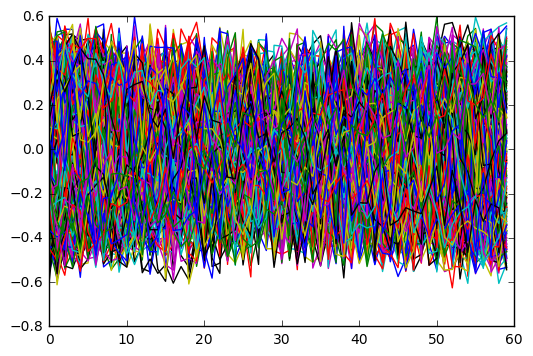

In [27]:
i=plt.plot(Y_test.T)

In [29]:
Ytest = Y_test.as_matrix()
utestHatMeansBar = (Ytest*phiHatExpBar )* KpNn*KpnnInv*uHatVsBar
#Update for u 
M = np.matrix(KpnnInv * KpNn.T)
utestExpBar = utestHatMeansBar * M

In [51]:
Tn = Ytest.shape[0]
ltest=np.zeros(Tn)
Lpred=np.zeros(Tn)
LpredUnBiased = np.zeros(Tn)
for t in range(Tn):
    ltest[t] = np.dot(utestExpBar[t,:] ,WHatExp.T) + BHatExp[0,0]
    Lpred[t] = guessLabel(ltest[t])
    LpredUnBiased[t] = guessLabel(ltest[t],mu=BHatExp[0])

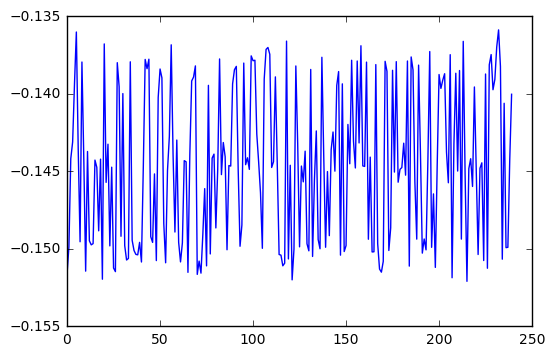

In [41]:
plt.plot(ltest)

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
       -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1

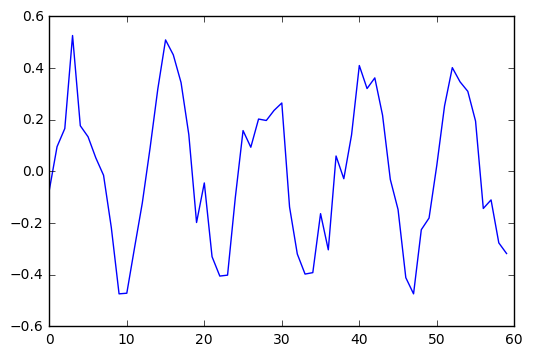

In [66]:
i=plt.plot(YBar[2].T)

In [60]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics
print metrics.classification_report(y_pred=LP,y_true=L_test.values)

             precision    recall  f1-score   support

       -1.0       0.82      1.00      0.90       196
        1.0       0.00      0.00      0.00        44

avg / total       0.67      0.82      0.73       240



 /home/sudhanshu/miniconda2/lib/python2.7/site-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning:Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
